# Interpretable Machine Learning with LIME 
By: Cristian Arteaga, [arteagac.github.io](https://arteagac.github.io)

![Image](https://arteagac.github.io/blog/lime/img/banner.png)

In this step by step guide with python code, we will study the details behind a popular technique for interpretable machine learning called LIME (Local Interpretable Model-agnostic Explanations). This technique was proposed by Rubiero et. al. in their paper "Why should I trust you?: Explaining the predictions of any classifier" on 2016 ([See paper here](https://arxiv.org/abs/1602.04938)). 


## Initialization

### Imports and global settings
Regular python tools for data manipulation and plotting are imported. In addition, a function to set the style of plots is declared. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
gray_cmap=LinearSegmentedColormap.from_list('gy',[(.3,.3,.3),(.8,.8,.8)], N=2) 
np.random.seed(222) #Seed for random numbers generation

def set_plot_style():
  plt.axis([-2,2,-2,2])
  plt.xlabel('x1')
  plt.ylabel('x2')

### Read and standarize data
An artificial dataset with two explanatory variables as input and one categorical binary variable as output is used here. This dataset was manually designed to intentionally represent an underlying data generation process with non-linear decision boundaries. The first 5 elements of this dataset and a plot of the underlying data generation process are shown below.

In [3]:
df = pd.read_csv("https://arteagac.github.io/blog/lime/artificial_data.csv",header = 'infer')
df[0:5]

,x1,x2,y
0,14.48,27.10,0
1,13.83,26.85,0
2,13.18,26.70,0
3,12.53,26.50,0
4,11.58,26.25,0


The explanatory variables are saved in the array `X` and the output in `y`. To avoid issues due to the units of the explanatory variables the data is standarized using normal standarization. This is a regularly recommended practice in machine learning. 

In [4]:
X = df[['x1','x2']].values
y = df['y'].values
X = (X - np.mean(X,axis=0)) / np.std(X,axis=0) #Standarization of data

The following plot represents the underlying data generation process in the dataset. The axis represent the input variables `x1` and `x2` and the color (soft and dark gray) represent the class that the element belongs to. 

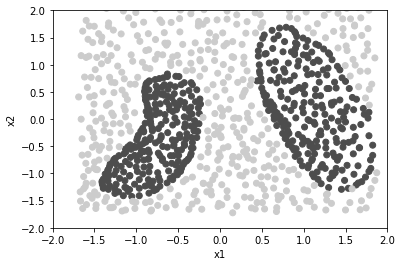

In [5]:
set_plot_style()
plt.scatter(X[:,0],X[:,1], c=y, cmap=gray_cmap)

### Train a machine-learning classifier
A random forest classifier is trained with the previous data. Remember that this is a binary classification problem. 

In [6]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, y) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

A mesh grid is created in order to observe the decision boundaries of the trained classifier. If you are not familiar with concept of mesh grid or plotting of decision boundaries you can think of it as sampling a lot of `x1` and `x2` values in a specific range and use the machine learnig classifier to predict the output and visually observe the decision boundaries fo the trained model. The plot shown below illustrates the decision boundaries of the classifier and it can be noted that they are very similar to the underlying data generation process. Even though we should always control for overfitting, in this case it is not necessarily a problem because we can visually inferr that the decision boundaries of the classifier match the data generation process.

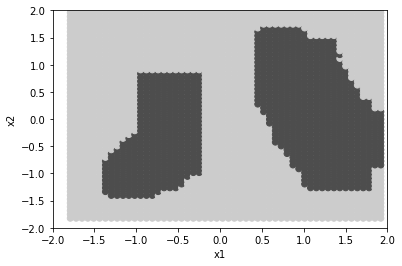

In [7]:
#Function to create a mesh grid
def make_meshgrid(x1, x2, h=.02,x1_min=0,x1_max=0,x2_min=0,x2_max=0):
    if x1_min==0 and x1_max==0 and x2_min==0 and x2_max==0:
        x1_min, x1_max = x1.min() - 0.1, x1.max() + 0.1
        x2_min, x2_max = x2.min() - 0.1, x2.max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return np.vstack((xx1.ravel(), xx2.ravel())).T

#Create mesh grid and predict class for each element in mesh grid
XX = make_meshgrid(X[:,0],X[:,1],h=.07)
yy = classifier.predict(XX)

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)

## LIME Explanations
LIME generates local explanations, in other words, explanations for individual instances in a dataset. LIME starts by generating a new dataset of perturbations around the instance to be explained. Then, the trained machine learning classifier is used to predict the class of each instance in the new generated dataset. Finally, a simpler model with intrinsic intepretability, for instance a linear regression model, is fitted and used to explain the prediction of the classifier. Before fitting a simpler model, the instances in the new generated dataset are weighed based on their distance to the original instance being explained. In this way, there is a higher certainty that the model is locally faithful around the explained instance. 

In this example, as shown in the plot below, we want to explain the prediction of the blue dot (instance with x1 = 0.8 and x2 = -0.7).

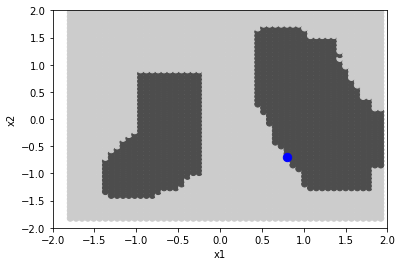

In [8]:
Xi = np.array([0.8,-0.7]) 
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

### Step 1. Generate random perturbations around the instance being explained
For the case of tabular data, sampling around the mean and standard deviation of the explanatory variables is recommended. Given that the dataset used in this example was normally standarized in a previous step, a normal random sample with mean 0 and standard deviation 1 is generated and stored in the 2D array `X_lime` as shown below. At this point, we still do not know the class for each element in this sample. Such class is predicted in the next step.

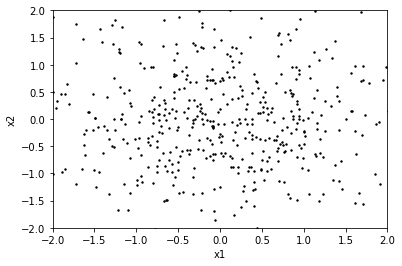

In [9]:
num_perturb = 500
X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))

set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=2,c="black")

### Step 2: Use ML classifier to predict classes of new generated dataset
The random forest classifier trained in previous steps is used here to predict the class of each pair (x1,x2) in the new generated dataset.

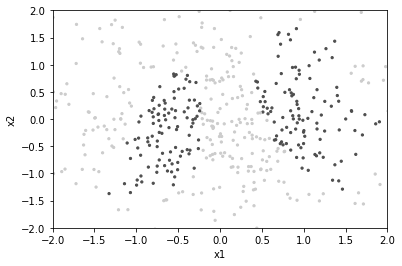

In [10]:
y_lime = classifier.predict(X_lime)
set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=5, c=y_lime, cmap=gray_cmap)

In [11]:
classifier.predict(np.array([0.8,-0.7]).reshape(1, -1) )


array([1])

### Step 3: Compute distances between the instance being explained and each perturbation and compute weights (importance) of the generated instances
The distance between each randomly generated instance and the instance being explained is computed using the euclidean distance. For explanations of other types of data such as image or text data the cosine distance can be used. Such distances are then mapped to a value between zero and one (weight) using a kernel function. Depeding on how we set the kernel width it shows how wide we define the "locality" around our instance. For tabular data the definition of a kernel width needs special atention, specially if the data has not been standarized. A more detailed discussion on this topic of kernel width can be found in the book ["Interpretable Machine Learning" by Cristoph Molnar](https://christophm.github.io/interpretable-ml-book/) in section 5.7. In the code below, the shape of the weights is shown and it can be noted that for each instance in the new randomly generated dataset, there is a corresponding weight or importance value.

In [12]:
kernel_width = 0.2
distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
weights.shape

(500,)

The plot below shows how these weights would look like around the instance being explained. Green markers represent larger weights or instance with higher importance.

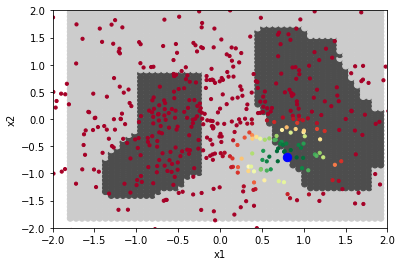

In [13]:
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights,cmap="RdYlGn") 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

### Step 4: Use the new generated dataset (`X_lime`), its class predictions (`y_lime`) and their importance (`weights`) to fit simpler and interpretable (linear) model
A linear model is fitted as shown below. This linear model generates new decision boundaries that are locally faitful around the explained instance. This linear decision boundary can be seen with the markers with + and - symbol. It is important to emphasize that this new linear decision boundary is not globally faithful because it is supposed to be a proper discriminator only in the locallity of the instance being explained (blue dot). 

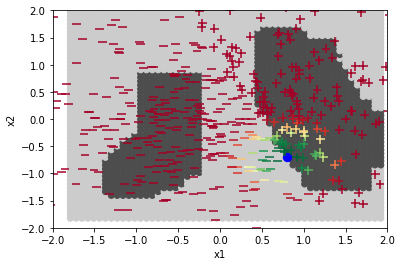

In [14]:
from sklearn.linear_model import LinearRegression
simpler_model = LinearRegression() 
simpler_model.fit(X_lime, y_lime, sample_weight=weights)
y_linmodel = simpler_model.predict(X_lime)
y_linmodel = y_linmodel < 0.5 #Conver to binary class

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
plt.scatter(X_lime[y_linmodel==0,0],X_lime[y_linmodel==0,1],c= weights[y_linmodel==0],cmap="RdYlGn",marker="_",s=80)
plt.scatter(X_lime[y_linmodel==1,0],X_lime[y_linmodel==1,1],c= weights[y_linmodel==1],cmap="RdYlGn",marker="+",s=80)

The coefficients of this estimated linear model can be used to understand how changes in the explanatoriy variables affect the classification output for the instance being explained. For example, as shown below, the estimated coefficients suggest that for the instance being explained, increasing the values of x1 and x2 will cause the prediction to lean towards the prediction of the negative class (darker area).

In [15]:
simpler_model.coef_

array([-1.37295625, -0.61209681])

In this notebook we have studied the basics of how LIME for tabular data works. The concepts covered here are easily transferrable to explanations of other types of data such as text and image data. For an insteresting discussion about some strengths and limitations of LIME please refer to the book ["Interpretable Machine Learning" by Cristoph Molnar](https://christophm.github.io/interpretable-ml-book/).